In [1700]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
import warnings
warnings.filterwarnings("ignore")
# Show all columns of dataframe
pd.set_option("display.max_columns", None)

In [1701]:
df = pd.read_csv("/Users/niklashemmer/Documents/Soccer data.csv")

In [1702]:
# Filter all transfers from 2009
df = df[df["year"] > 2009]

In [1703]:
#Delete all Loanees 
df = df[~df["fee"].str.contains("loan|Loan", na=False)]
df.drop(["fee", "league_code", "year"], axis=1, inplace=True)
df.head()

,club_name,player_name,age,position,club_involved_name,transfer_movement,transfer_period,fee_cleaned,league_name,season
6879,VfL Wolfsburg,Akaki Gogia,18.0,Right Winger,Wolfsburg II,in,Winter,0.000,1 Bundesliga,2010/2011
6881,SC Freiburg,Alain Junior Ollé Ollé,23.0,Left Midfield,Stabæk Fotball,out,Winter,0.000,1 Bundesliga,2010/2011
6882,1.FC Kaiserslautern,Alan Stulin,20.0,Left-Back,K'lautern II,in,Summer,0.000,1 Bundesliga,2010/2011
6884,VfB Stuttgart,Alessandro Riedle,19.0,Central Midfield,Grasshoppers,out,Summer,NaN,1 Bundesliga,2010/2011
6886,Eintracht Frankfurt,Alexander Dercho (Krük),23.0,Left-Back,VfL Osnabrück,out,Summer,0.045,1 Bundesliga,2010/2011


# 1. Data Preparation/Data Checks

In [1704]:
df[df["player_name"] == "Shinji Kagawa"]

,club_name,player_name,age,position,club_involved_name,transfer_movement,transfer_period,fee_cleaned,league_name,season
7317,Borussia Dortmund,Shinji Kagawa,21.0,Attacking Midfield,Cerezo Osaka,in,Summer,0.0,1 Bundesliga,2010/2011
8413,Borussia Dortmund,Shinji Kagawa,23.0,Attacking Midfield,Man Utd,out,Summer,14.4,1 Bundesliga,2012/2013
9490,Borussia Dortmund,Shinji Kagawa,25.0,Attacking Midfield,Man Utd,in,Summer,7.2,1 Bundesliga,2014/2015
12319,Borussia Dortmund,Shinji Kagawa,30.0,Attacking Midfield,Real Zaragoza,out,Summer,2.7,1 Bundesliga,2019/2020
108239,Manchester United,Shinji Kagawa,23.0,Attacking Midfield,Bor. Dortmund,in,Summer,14.4,Premier League,2012/2013
110407,Manchester United,Shinji Kagawa,25.0,Attacking Midfield,Bor. Dortmund,out,Summer,7.2,Premier League,2014/2015


I'm aggregating players who played twice for a certain club. This is not an optimal solution but sufficient for our purpose. Keeping those transfers separate would make it more complicated to match the purchase and sale in one line and calculate the profit (if you know a better solution, please reach out)

In [1705]:
# Group players who placed twice for one specific club
df1 = df.groupby(["player_name", "club_name", "transfer_movement", "league_name"], as_index=False)["fee_cleaned"].sum()

In [1706]:
df1[df1["player_name"] == "Shinji Kagawa"]

,player_name,club_name,transfer_movement,league_name,fee_cleaned
27293,Shinji Kagawa,Borussia Dortmund,in,1 Bundesliga,7.2
27294,Shinji Kagawa,Borussia Dortmund,out,1 Bundesliga,17.1
27295,Shinji Kagawa,Manchester United,in,Premier League,14.4
27296,Shinji Kagawa,Manchester United,out,Premier League,7.2


Now we can split the dataset based on the column "transfer_movement" and merge it again. We want only one row per player transfer. Currently, we have one row for Götze's purchase from Bayern in 2013/2014 and one row for his sale in 2016/2017.

Note: We exclude players who where just bought and still play for their team. For example, Götze still plays for Eindhoven. We don't know if they will be able to sell him on for a profit at some point, so we ignore him

In [1707]:
df_in = df1[df1["transfer_movement"] == "in"]
df_out = df1[df1["transfer_movement"] == "out"]

In [1708]:
df_all = pd.merge(df_in, df_out, on=["player_name", "club_name"], suffixes=("_in", "_out"))
df_all.head()

,player_name,club_name,transfer_movement_in,league_name_in,fee_cleaned_in,transfer_movement_out,league_name_out,fee_cleaned_out
0,Aapo Halme,Leeds United,in,Championship,0.504,out,Championship,0.203
1,Aaron Boupendza,FC Girondins Bordeaux,in,Ligue 1,0.000,out,Ligue 1,0.000
2,Aaron Cole,Derby County,in,Championship,0.000,out,Championship,0.000
3,Aaron Collins,Wolverhampton Wanderers,in,Championship,0.069,out,Premier League,0.000
4,Aaron Cresswell,Ipswich Town,in,Championship,0.248,out,Championship,4.280


In [1709]:
df_all[df_all["player_name"] == "Mario Götze"]

,player_name,club_name,transfer_movement_in,league_name_in,fee_cleaned_in,transfer_movement_out,league_name_out,fee_cleaned_out
5849,Mario Götze,Bayern Munich,in,1 Bundesliga,33.3,out,1 Bundesliga,19.8
5850,Mario Götze,Borussia Dortmund,in,1 Bundesliga,19.8,out,1 Bundesliga,33.3


In [1710]:
# Check for duplicates
duplicates = df_all.duplicated()
duplicates.sum()

0

In [1711]:
# Check for NaNs
df_all.isna().sum()

player_name              0
club_name                0
transfer_movement_in     0
league_name_in           0
fee_cleaned_in           0
transfer_movement_out    0
league_name_out          0
fee_cleaned_out          0
dtype: int64

In [1712]:
# Calculate the profits/loss
df_all["Profit"] = df_all["fee_cleaned_out"] - df_all["fee_cleaned_in"]
df_all.head(2)

,player_name,club_name,transfer_movement_in,league_name_in,fee_cleaned_in,transfer_movement_out,league_name_out,fee_cleaned_out,Profit
0,Aapo Halme,Leeds United,in,Championship,0.504,out,Championship,0.203,-0.301
1,Aaron Boupendza,FC Girondins Bordeaux,in,Ligue 1,0.000,out,Ligue 1,0.000,0.000


In [1713]:
df_all.shape

(9652, 9)

We have 9652 players left that we can analyze now. I will start by doing some exploratory analysis

# 2. Exploratory Data Analysis

<function matplotlib.pyplot.show(*args, **kw)>

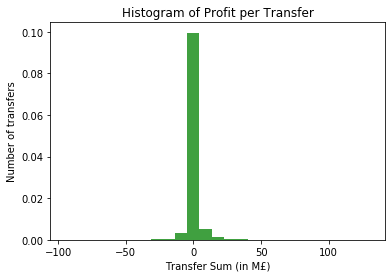

In [1714]:
plt.hist(df_all["Profit"], bins = 25, density=1, facecolor="g", alpha=0.75)
plt.title("Histogram of Profit per Transfer")
plt.xlabel("Transfer Sum (in M£)")
plt.ylabel ("Number of transfers")
plt.show

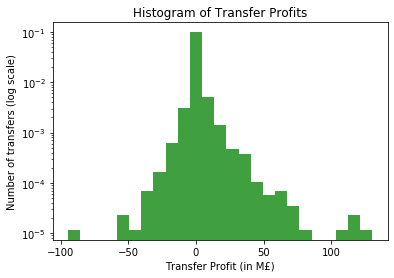

In [1715]:
# Let's look at the same graph with a log scale 
plt.hist(df_all["Profit"], bins = 25, density=1, facecolor="g", alpha=0.75, log=True)
plt.title("Histogram of Transfer Profits")
plt.xlabel("Transfer Profit (in M£)")
plt.ylabel ("Number of transfers (log scale)")

plt.show()

In [1716]:
mean = np.mean(df_all["Profit"])
mean

0.5166681516784072

In [1717]:
median = np.median(df_all["Profit"])
median

0.0

In [1718]:
mode = stats.mode(df_all["Profit"])
mode

ModeResult(mode=array([0.]), count=array([5364]))

In [1719]:
std = np.std(df_all["Profit"])
std

5.935496382256612

In [1720]:
skew = 3*(mean-median)/std
skew

0.26114150446940826

In [1721]:
# Calculate number of players that didn't generate a profit
no_profit = df_all[df_all["Profit"] <= 0]["player_name"].count()
no_profit

7591

In [1722]:
# Calculate number of players that didn't generate a profit in percentage 
no_profit_ratio = df_all[df_all["Profit"] <= 0]["player_name"].count()/df_all["player_name"].count()
no_profit_ratio

0.7864691255698301

# 3. Classify transfers based on ABC logic 

ABC classification is based on the Pareto principle, frequently used in supply chain for stock control. Instead of trying to manage every product at an individual level, ABC classification groups them so staff can prioritize some products over others. Based on criteria such as a revenue, it divides products into three classes: A, B, and C, where A products are the most important. 

In [1723]:
# Since we can't deal with negative values for cumulative analyses, we have to set all negative values to 0
df_all["Profit"]=df_all["Profit"].mask(df_all["Profit"].lt(0),0)

In [1724]:
# Sort the dataframe by profit and reset index
sorted_df = df_all.sort_values(by="Profit", ascending=False)
sorted_df = sorted_df.reset_index()

Before we start with our calculation, we introduce the ABC classification criteria. The limits for each class are somewhat arbitrary and might be changed depending on the case. Since ABC classification is based on the Pareto principle, the rule of thumb says that 20% of transfers make up for 80% of total profits. From our explanatory data analysis, we already know that this number will be lower but 80% can still serve as a good limit for class A. The rest goes to classes B and C.

In [1725]:
def classify(percentage):
    """Apply an ABC classification to each transfer based on 
    its cumulative percentage profit contribution. 
    
    :param percentage: Running percentage of profit contributed
    :return: ABC classification
    """
    
    if percentage > 0 and percentage <= 80:
        return 'A'
    elif percentage > 80 and percentage <= 95:
        return 'B'
    else:
        return 'C'

The ABC classes are calculated by calculating the cumulative sum of transfers and then calculating its running percentage of total transfers. The same procedure has to be done for cumulative transfer profits. 

In [1726]:
# Cumulate number of transfers 
sorted_df["ones"] = 1
sorted_df["cumcount"] = sorted_df["ones"].cumsum()

# in percentage 
sorted_df["cumcount%"] = (sorted_df["cumcount"] / sorted_df["cumcount"].max())*100

In [1727]:
# Cumulate transfer profits 
sorted_df["cumprofit"] = sorted_df["Profit"].cumsum()
sorted_df["profit%"] = (sorted_df["Profit"] / sorted_df["Profit"].sum())*100
sorted_df["cumprofit%"] = sorted_df["profit%"].cumsum()

In [1728]:
sorted_df.head(2)

,index,player_name,club_name,transfer_movement_in,league_name_in,fee_cleaned_in,transfer_movement_out,league_name_out,fee_cleaned_out,Profit,ones,cumcount,cumcount%,cumprofit,profit%,cumprofit%
0,5136,Kylian Mbappé,AS Monaco,in,Ligue 1,0.0,out,Ligue 1,130.5,130.5,1,1,0.010361,130.5,1.144006,1.144006
1,7318,Philippe Coutinho,Liverpool FC,in,Premier League,11.7,out,Premier League,130.5,118.8,1,2,0.020721,249.3,1.041440,2.185445


In [1729]:
# Write a function to create a line chart for the dataframe
def create_graph_total(df, a):
    fig, ax = plt.subplots(figsize = (10,6))
    ax.plot(df["cumcount%"], df["cumprofit%"], marker="o")
    ax.set_ylabel("Cumulative transfer profits (in %)")
    ax.set_xlabel("Cumulative number of transfers (in %)")
    ax.set_title("Transfer Profits vs. number of transfers")

    ax.axvline(a, color='r', linestyle="--")
    ax.axhline(80, color='r', linestyle="--")

    plt.show()

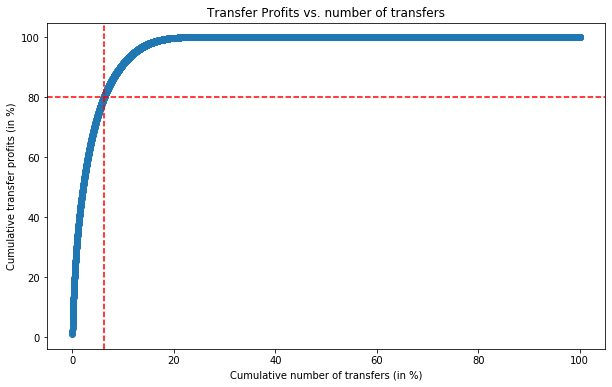

In [1730]:
create_graph_total(sorted_df, a=6.2)

Now we need to perform the classification and assign each transfer to its ABC Class

In [1731]:
# Apply the function
sorted_df['abc_class'] = sorted_df['cumprofit%'].apply(classify)
sorted_df['abc_rank'] = sorted_df['cumprofit%'].rank().astype(int)
sorted_df.tail(2)

,index,player_name,club_name,transfer_movement_in,league_name_in,fee_cleaned_in,transfer_movement_out,league_name_out,fee_cleaned_out,Profit,ones,cumcount,cumcount%,cumprofit,profit%,cumprofit%,abc_class,abc_rank
9650,3583,Hicham Belkaroui,Moreirense FC,in,Liga Nos,0.0,out,Liga Nos,0.0,0.0,1,9651,99.989639,11407.286,0.0,100.0,C,5856
9651,9651,Özkan Yildirim,SV Werder Bremen,in,1 Bundesliga,0.0,out,1 Bundesliga,0.0,0.0,1,9652,100.000000,11407.286,0.0,100.0,C,5856


In [1732]:
# Write a function to create ABC table
def abc_table_total(df):
    abc = df.groupby('abc_class').agg(
        cum_transfers=('ones', "count"),
        cum_profit=('Profit', sum),
        mean_profit=("Profit", "mean"),
        median_profit=("Profit", "median"),
        mean_purchase_fee=("fee_cleaned_in", "mean"),
        median_purchase_fee=("fee_cleaned_in", "median")
    )
    abc["cum_transfers %"] = (abc["cum_transfers"]/abc["cum_transfers"].sum()*100).round(2)
    cols= abc.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    abc = abc[cols]
    return abc.round(2)

In [1733]:
abc_table_total(sorted_df)

,cum_transfers %,cum_transfers,cum_profit,mean_profit,median_profit,mean_purchase_fee,median_purchase_fee
abc_class,,,,,,,
A,6.20,598,9122.14,15.25,10.8,3.45,0.53
B,6.01,580,1713.29,2.95,2.7,1.64,0.00
C,87.80,8474,571.85,0.07,0.0,1.18,0.00


---

# Evaluate selected clubs

After evaluating the entire dataset, we can now delve deeper into certain clubs and see if our findings replicate. Therefore, I will look at clubs who are well known for their successful recruitment strategies by sorting for the ten clubs who made the most profit.

In [1734]:
df_agg = sorted_df.groupby(["club_name"])["Profit"].sum()
df_agg.sort_values(ascending=False).head(10)

club_name
SL Benfica           642.231
AS Monaco            531.315
Ajax Amsterdam       405.770
FC Porto             369.335
Borussia Dortmund    354.550
Liverpool FC         346.259
LOSC Lille           321.920
Chelsea FC           318.706
Olympique Lyon       299.273
Sporting CP          285.047
Name: Profit, dtype: float64

In [1735]:
top_clubs = ["Borussia Dortmund", "AS Monaco", "Liverpool FC", "Ajax Amsterdam", "SL Benfica", "FC Porto", "LOSC Lille",
        "Chelsea FC", "Olympique Lyon", "Sporting CP"]

In [1736]:
# Write a function that cumulates the number of transfers and profits as well as assigns ABC classifications 
def abc_analysis(clubs, d={}):
    
    sorted_df = df_all.sort_values(by="Profit", ascending=False)
        
    for club in clubs:
                
        d[club] = sorted_df[sorted_df["club_name"] == club]
        d[club] = d[club].reset_index()

        #Cumulate number of transfers
        d[club]["ones"] = 1
        d[club]["cumcount"] = d[club]["ones"].cumsum()
        d[club]["cumcount%"] = d[club]["cumcount"] / d[club]["cumcount"].max()*100

        #Cumulate transfer profits 
        d[club]["cumprofit"] = d[club]["Profit"].cumsum()
        d[club]["profit%"] = d[club]["Profit"] / d[club]["Profit"].sum()
        d[club]["cumprofit%"] = d[club]["profit%"].cumsum()*100

        #Assign ABC classification
        d[club]['abc_class'] = d[club]['cumprofit%'].apply(classify)
        d[club]['abc_rank'] = d[club]['cumprofit%'].rank().astype(int)

In [1737]:
# Call function to conduct ABC analysis
abc_analysis(top_clubs, d=d)
d["SL Benfica"].head(2)

,index,player_name,club_name,transfer_movement_in,league_name_in,fee_cleaned_in,transfer_movement_out,league_name_out,fee_cleaned_out,Profit,ones,cumcount,cumcount%,cumprofit,profit%,cumprofit%,abc_class,abc_rank
0,4676,João Félix,SL Benfica,in,Liga Nos,0.0,out,Liga Nos,113.4,113.4,1,1,0.943396,113.4,0.176572,17.657198,A,1
1,8006,Rúben Dias,SL Benfica,in,Liga Nos,0.0,out,Liga Nos,61.2,61.2,1,2,1.886792,174.6,0.095293,27.186480,A,2


In [1738]:
# Write a function that creates charts for each individual team
def create_graph_ind(d=d):
    for key in d.keys():
        fig, ax = plt.subplots(figsize = (5,3))
        ax.plot(d[key]["cumcount%"], d[key]["cumprofit%"], marker="o")
        ax.plot(d[key]["cumcount%"], d[key]["cumprofit%"], marker="o")
        ax.set_ylabel("Cumulative transfer profits (in %)")
        ax.set_xlabel("Cumulative number of transfers (in %)")
        #ax.set_title(df["club_name"])

        ax2 = ax.twinx()
        ax2.set_ylabel("Cumulative transfer profits (in %)")

        plt.show()

In [1739]:
#create_graph_ind()

In [1740]:
# Write a function that creates one chart for all clubs 
def create_graph_all(d=d):
    fig, ax = plt.subplots(figsize = (10,6))
    for key in d.keys():
        ax.plot(d[key]["cumcount%"], d[key]["cumprofit%"], marker="o")
    ax.set_ylabel("Cumulative transfer profits (in %)")
    ax.set_xlabel("Cumulative number of transfers (in %)")
    ax.set_title("Transfer Profits vs. number of transfers")
    plt.legend(d)

    plt.show()

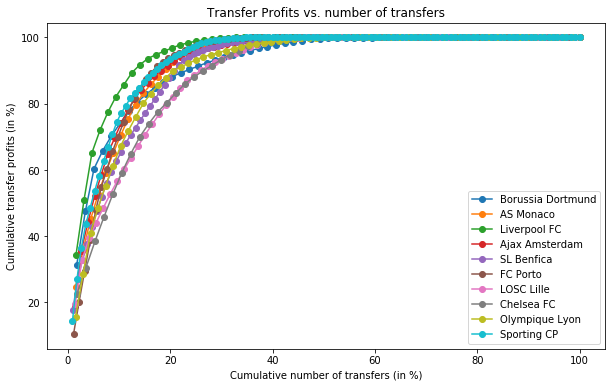

In [1741]:
create_graph_all()

In [1742]:
# Write a function that creates a table to evaluate the most important numbers
def abc_table(d, club):
    abc_top = d[club].groupby('abc_class').agg(
        cum_transfers=('cumcount%', "count"),
        cum_profit=('Profit', sum),
        mean_profit=("Profit", "mean"),
        median_profit=("Profit", "median"),
        mean_purchase_fee=("fee_cleaned_in", "mean"),
        median_purchase_fee=("fee_cleaned_in", "median")
    )
    abc_top["cum_transfers %"] = (abc_top["cum_transfers"]/abc_top["cum_transfers"].sum()*100).round(2)
    cols=abc_top.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    abc_top = abc_top[cols]

    return abc_top.round(2)

In [1743]:
abc_table(d, "SL Benfica")

,cum_transfers %,cum_transfers,cum_profit,mean_profit,median_profit,mean_purchase_fee,median_purchase_fee
abc_class,,,,,,,
A,16.04,17,509.45,29.97,21.6,3.17,0.00
B,8.49,9,100.39,11.15,13.0,2.39,0.36
C,75.47,80,32.39,0.40,0.0,1.85,0.40


In [1744]:
abc_table(d, "Ajax Amsterdam")

,cum_transfers %,cum_transfers,cum_profit,mean_profit,median_profit,mean_purchase_fee,median_purchase_fee
abc_class,,,,,,,
A,11.69,9,316.31,35.15,26.28,1.88,0.0
B,11.69,9,68.85,7.65,6.59,1.65,0.0
C,76.62,59,20.61,0.35,0.00,1.46,0.0


In [1745]:
abc_table(d, "Olympique Lyon")

,cum_transfers %,cum_transfers,cum_profit,mean_profit,median_profit,mean_purchase_fee,median_purchase_fee
abc_class,,,,,,,
A,13.24,9,227.48,25.28,20.16,1.56,0.00
B,14.71,10,56.29,5.63,4.90,2.88,0.66
C,72.06,49,15.50,0.32,0.00,1.94,0.00


### All selected clubs combined

In [1747]:
# Sort the dataframe by profit and reset index
df_top = df_top.sort_values(by="Profit", ascending=False)
#df_top = df_top.reset_index()

# Cumulate number of transfers 
df_top["ones"] = 1
df_top["cumcount"] = df_top["ones"].cumsum()
df_top["cumcount%"] = (df_top["cumcount"] / df_top["cumcount"].max())*100

df_top["cumprofit"] = df_top["Profit"].cumsum()
df_top["profit%"] = (df_top["Profit"] / df_top["Profit"].sum())*100
df_top["cumprofit%"] = df_top["profit%"].cumsum()

# Apply ABC function to classify
df_top['abc_class'] = df_top['cumprofit%'].apply(classify)
df_top['abc_rank'] = df_top['cumprofit%'].rank().astype(int)

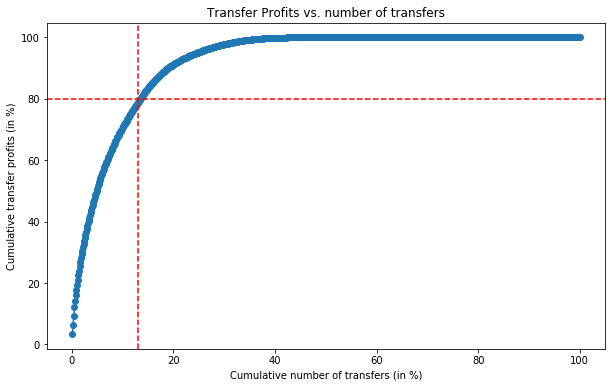

In [1748]:
# Call function to create chart
create_graph_total(df_top, a=13.1)

In [1749]:
# Call function to create ABC table
abc_table_total(df_top)

,cum_transfers %,cum_transfers,cum_profit,mean_profit,median_profit,mean_purchase_fee,median_purchase_fee
abc_class,,,,,,,
A,13.35,104,3087.52,29.69,20.61,6.10,2.43
B,11.17,87,590.65,6.79,6.30,3.73,0.68
C,75.48,588,196.23,0.33,0.00,3.16,0.43


---

# Premier League

In [1750]:
clubs1 = ["Manchester United", "Manchester City", "Liverpool FC", "Chelsea FC", "Arsenal FC", "Tottenham Hotspurs",
         "West Ham United", "Leicester City", "Brighton & Hove Albion", "Southampton FC", 'Crystal Palace', 'Everton FC',
         'Newcastle United', 'Aston Villa', "Wolverhampton Wanderers", 'Norwich City', 'Watford FC']

In [1751]:
# Call function to create abc analysis
x={}
abc_analysis(clubs1, d=x)

In [1752]:
x["Arsenal FC"].head(2)

,index,player_name,club_name,transfer_movement_in,league_name_in,fee_cleaned_in,transfer_movement_out,league_name_out,fee_cleaned_out,Profit,ones,cumcount,cumcount%,cumprofit,profit%,cumprofit%,abc_class,abc_rank
0,414,Alex Iwobi,Arsenal FC,in,Premier League,0.00,out,Premier League,27.36,27.36,1,1,1.923077,27.36,0.277063,27.706329,A,1
1,426,Alex Oxlade-Chamberlain,Arsenal FC,in,Premier League,12.42,out,Premier League,34.20,21.78,1,2,3.846154,49.14,0.220557,49.762025,A,2


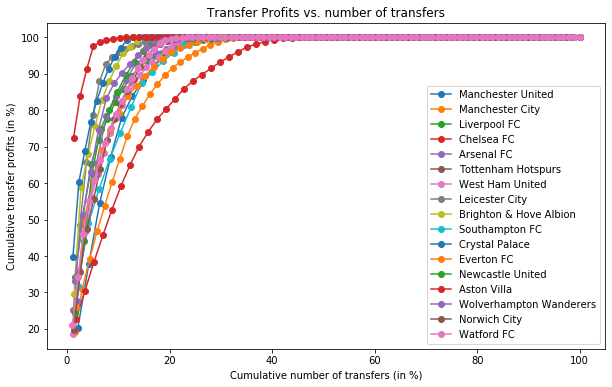

In [1753]:
# Call function to create a graph with all individual lines
create_graph_all(d=x)

In [1754]:
# Call function to create ABC table for Aston Villa
abc_table(x, "Aston Villa")

,cum_transfers %,cum_transfers,cum_profit,mean_profit,median_profit,mean_purchase_fee,median_purchase_fee
abc_class,,,,,,,
A,1.28,1,33.93,33.93,33.93,7.92,7.92
B,2.56,2,8.82,4.41,4.41,0.00,0.00
C,96.15,75,4.11,0.05,0.00,3.14,2.07


### All Premier League clubs combined

In [1755]:
# Create dataframe
df_epl = df_all[df_all["club_name"].isin(clubs1)]

# Sort the dataframe by profit and reset index
df_epl = df_epl.sort_values(by="Profit", ascending=False)
df_epl = df_epl.reset_index()

# Cumulate number of transfers 
df_epl["ones"] = 1
df_epl["cumcount"] = df_epl["ones"].cumsum()
df_epl["cumcount%"] = (df_epl["cumcount"] / df_epl["cumcount"].max())*100

df_epl["cumprofit"] = df_epl["Profit"].cumsum()
df_epl["profit%"] = (df_epl["Profit"] / df_epl["Profit"].sum())*100
df_epl["cumprofit%"] = df_epl["profit%"].cumsum()

# Apply ABC function to classify
df_epl['abc_class'] = df_epl['cumprofit%'].apply(classify)
df_epl['abc_rank'] = df_epl['cumprofit%'].rank().astype(int)

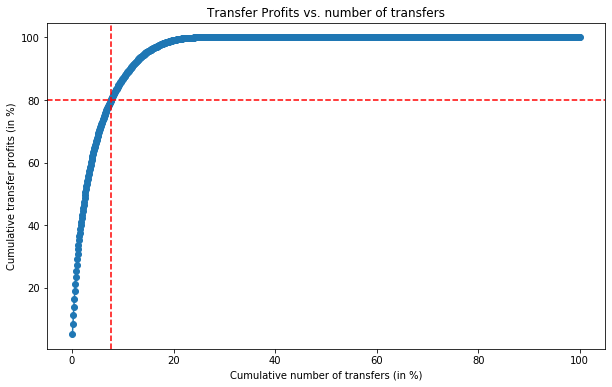

In [1757]:
# Call function to create chart
create_graph_total(df_epl, a=7.6)

In [1756]:
# Call function to create ABC table
abc_table_total(df_epl)

,cum_transfers %,cum_transfers,cum_profit,mean_profit,median_profit,mean_purchase_fee,median_purchase_fee
abc_class,,,,,,,
A,7.60,83,1842.16,22.19,15.3,5.78,1.62
B,6.87,75,350.87,4.68,4.5,3.83,0.76
C,85.53,934,115.68,0.12,0.0,4.03,0.07
